# Задача 4. Ансамбли

* **Дедлайн**: 26.03.2023, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [ ] Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.
- [ ] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [ ] Самостоятельно реализуйте алгоритмы **Bagging** и **AdaBoost**, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
- [ ] Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из **sklearn** (**Bagging**, **Random Forest**, **AdaBoost**, **Gradient Tree Boosting**, **Histogram-Based Gradient Boosting**).
- [ ] При обучении использовать **подбор гиперпараметров**, **кросс-валидацию**.
- [ ] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.
- [ ] * (**+2 балла**) Также добавить в сравнение модели из библиотек **XGBoost**, **LightGBM** и **CatBoost**.
- [ ] * (**+3 балла**) Для подбора гиперпараметров использовать фреймворк **Optuna**.

# Датасет
В качестве датасета было решено взять [этот](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction).
Так как количество данных в датасете огромно, а задание позволяет, было решено оставить лишь 10000 из них.

In [725]:
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks')
sns.set_palette("viridis")

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, \
    HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings

warnings.filterwarnings('ignore')

In [726]:
data = pd.read_csv("../data/airline/airline.csv")
data = data.sample(10000)
data

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
38484,38484,Indigo,6E-2169,Delhi,Evening,zero,Night,Chennai,Economy,2.92,23,2637
20391,20391,Indigo,6E-5041,Delhi,Evening,one,Late_Night,Kolkata,Economy,6.83,3,9373
174530,174530,Air_India,AI-9518,Hyderabad,Night,one,Early_Morning,Kolkata,Economy,8.50,35,5029
247229,247229,Air_India,AI-640,Bangalore,Early_Morning,one,Evening,Delhi,Business,12.58,32,42521
268375,268375,Vistara,UK-720,Kolkata,Early_Morning,one,Night,Bangalore,Business,13.25,19,60978
...,...,...,...,...,...,...,...,...,...,...,...,...
133143,133143,Vistara,UK-706,Kolkata,Morning,one,Night,Mumbai,Economy,10.50,35,9807
39047,39047,Air_India,AI-441,Delhi,Evening,one,Early_Morning,Chennai,Economy,13.50,26,3988
289070,289070,Vistara,UK-826,Chennai,Afternoon,one,Night,Delhi,Business,10.50,27,57920
126178,126178,Air_India,AI-763,Kolkata,Early_Morning,zero,Morning,Delhi,Economy,2.25,42,3016


# Разведочный анализ данных (EDA)

In [727]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 38484 to 154771
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        10000 non-null  int64  
 1   airline           10000 non-null  object 
 2   flight            10000 non-null  object 
 3   source_city       10000 non-null  object 
 4   departure_time    10000 non-null  object 
 5   stops             10000 non-null  object 
 6   arrival_time      10000 non-null  object 
 7   destination_city  10000 non-null  object 
 8   class             10000 non-null  object 
 9   duration          10000 non-null  float64
 10  days_left         10000 non-null  int64  
 11  price             10000 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 1015.6+ KB


Пропущенные значения в датасете отсутствуют, поэтому никаких дополнительных манипуляций со строками не требуется.

In [728]:
data = data.drop(['Unnamed: 0'], axis=1)

In [729]:
data.describe()

,duration,days_left,price
count,10000.000000,10000.000000,10000.000000
mean,12.299151,26.027200,21011.180000
std,7.244030,13.581396,22680.123932
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4855.000000
50%,11.250000,26.000000,7466.500000
75%,16.170000,38.000000,42521.000000
max,45.830000,49.000000,111964.000000


In [730]:
data.nunique()

airline                6
flight              1127
source_city            6
departure_time         6
stops                  3
arrival_time           6
destination_city       6
class                  2
duration             389
days_left             49
price               3091
dtype: int64

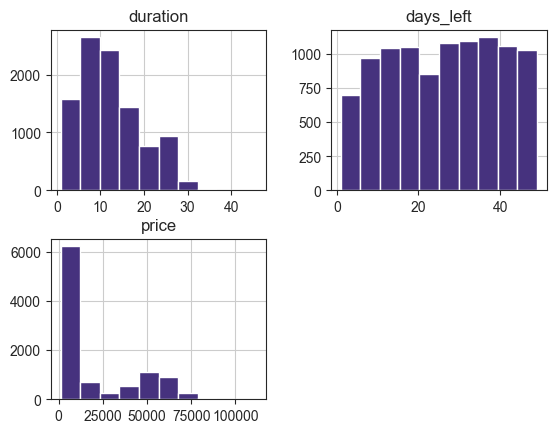

In [731]:
data.hist()
plt.show()

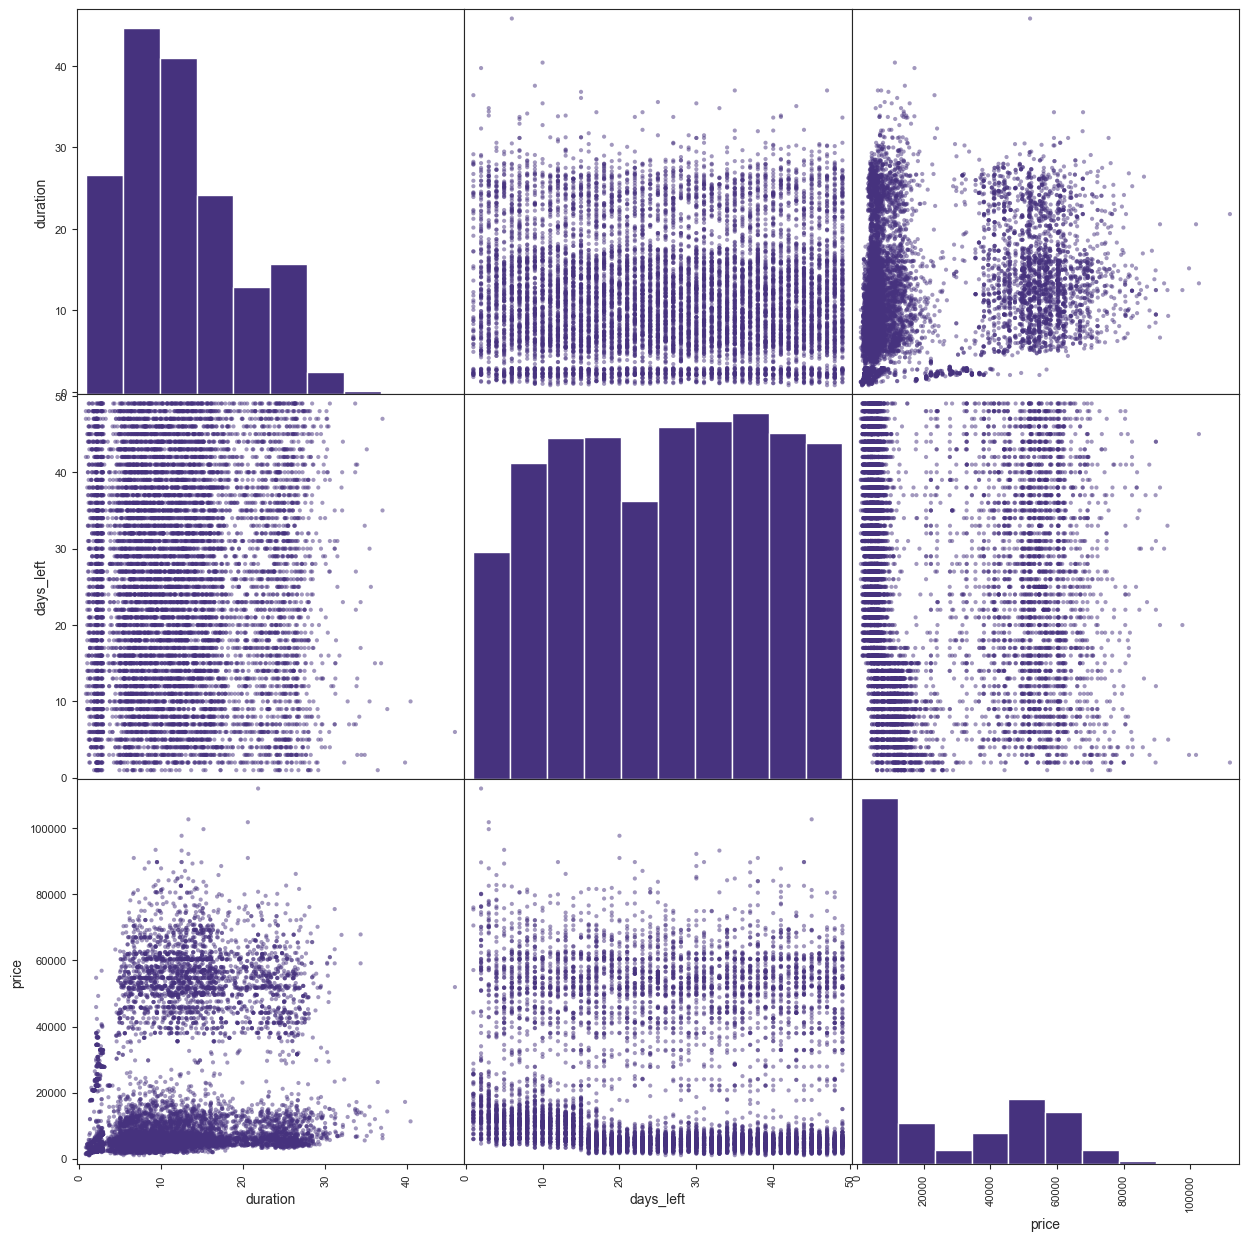

In [732]:
pd.plotting.scatter_matrix(data, figsize=(15, 15))
plt.show()

<Axes: >

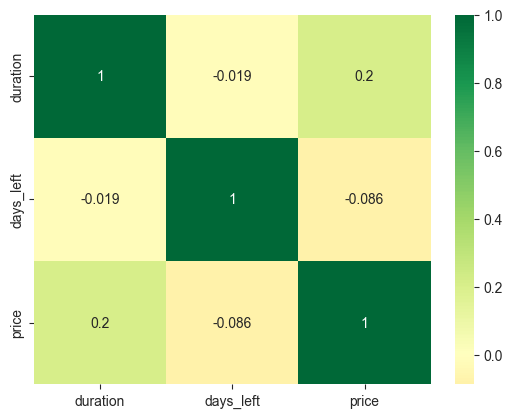

In [733]:
sns.heatmap(data.corr(), center=0, annot=True, cmap="RdYlGn")

Прослеживается коррелляция между длительностью полета и его стоимостью.

In [734]:
le = LabelEncoder()
data = data.apply(lambda x: le.fit_transform(x) if x.dtype == 'object' else x)
data

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
38484,3,67,2,2,2,5,1,1,2.92,23,2637
20391,3,172,2,2,0,3,4,1,6.83,3,9373
174530,1,625,3,5,0,1,4,1,8.50,35,5029
247229,1,545,0,1,0,2,2,0,12.58,32,42521
268375,5,1011,4,1,0,5,0,0,13.25,19,60978
...,...,...,...,...,...,...,...,...,...,...,...
133143,5,1008,4,4,0,5,5,1,10.50,35,9807
39047,1,472,2,2,0,1,1,1,13.50,26,3988
289070,5,1047,1,0,0,5,2,0,10.50,27,57920
126178,1,580,4,1,2,4,2,1,2.25,42,3016


Все ячейки, данные которых представлены типом object, преобразуем в числа.

<Axes: >

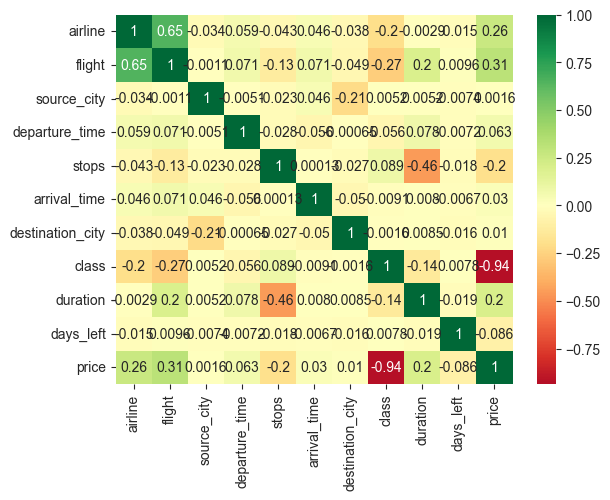

In [735]:
sns.heatmap(data.corr(), center=0, annot=True, cmap="RdYlGn")

После преобразований так же можно увидеть очень сильную зависимость между классом и ценой и более слабые зависимости цены от самолета, рейса и числа остановок.

# Реализация Bagging и AdaBoost

In [736]:
from sklearn.utils.validation import _num_samples, check_is_fitted
from sklearn.utils import check_X_y
from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.utils.extmath import stable_cumsum
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import check_random_state

## Bagging

In [737]:
class MyBaggingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=5, random_state=None):
        self.n_estimators = n_estimators
        self.random_state = random_state

    def _set_random_states(self, estimator):
        random_states = {}
        for param_name in estimator.get_params(deep=True):
            if param_name == "random_state" or param_name.endswith("__random_state"):
                random_states[param_name] = self.random_state_.randint(np.iinfo(np.int32).max)
        estimator.set_params(**random_states)

    def fit(self, X, y):
        self.estimators_ = []
        self.random_state_ = check_random_state(self.random_state)

        X, y = check_X_y(X, y, y_numeric=True)

        for _ in range(self.n_estimators):
            estimator = DecisionTreeRegressor()
            self._set_random_states(estimator)
            random_indices = self.random_state_.choice(len(y), len(y))
            X_sample, y_sample = X[random_indices], y[random_indices]
            estimator.fit(X_sample, y_sample)
            self.estimators_.append(estimator)

        self.n_features_in_ = X.shape[1]
        return self

    def predict(self, X):
        check_is_fitted(self)
        predictions = [estimator.predict(X) for estimator in self.estimators_]

        return np.mean(predictions, axis=0)


check_estimator(MyBaggingRegressor())

In [738]:
class MyAdaBoostRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=5, random_state=None):
        self.n_estimators = n_estimators
        self.random_state = random_state

    def _set_random_states(self, estimator):
        random_states = {}
        for param_name in estimator.get_params(deep=True):
            if param_name == "random_state" or param_name.endswith("__random_state"):
                random_states[param_name] = self.random_state_.randint(np.iinfo(np.int32).max)
        estimator.set_params(**random_states)

    def fit(self, X, y):
        X, y = check_X_y(X, y, y_numeric=True)

        self.random_state_ = check_random_state(self.random_state)
        self.estimators_ = []
        self.estimator_weights_ = []

        weights = np.full(len(y), fill_value=(1 / len(y)))
        for _ in range(self.n_estimators):
            estimator = DecisionTreeRegressor()
            self._set_random_states(estimator)
            y_predict = estimator.fit(X, y, sample_weight=weights).predict(X)

            errors = np.abs(y_predict - y)
            error_max = errors.max()
            if error_max > 0:
                errors /= error_max
            estimator_error = (errors * weights).sum()

            if estimator_error <= 0:
                self.estimators_.append(estimator)
                self.estimator_weights_.append(1.0)
                break
            elif estimator_error >= 0.5:
                if len(self.estimators_) == 0:
                    self.estimators_.append(estimator)
                    self.estimator_weights_.append(1.0)
                break

            beta = estimator_error / (1.0 - estimator_error)
            weights *= np.power(beta, (1.0 - errors))

            weights /= np.sum(weights)
            self.estimators_.append(estimator)
            self.estimator_weights_.append(np.log(1 / beta))

        self._estimator_weights = np.array(self.estimator_weights_)
        self.n_features_in_ = X.shape[1]

        return self

    def predict(self, X):
        check_is_fitted(self)
        predictions = np.array([est.predict(X) for est in self.estimators_]).T

        sorted_idx = np.argsort(predictions, axis=1)

        weight_cdf = stable_cumsum(self._estimator_weights[sorted_idx], axis=1)
        median_or_above = weight_cdf >= 0.5 * weight_cdf[:, -1][:, np.newaxis]
        median_idx = np.argmax(median_or_above, axis=1)
        median_idx = sorted_idx[np.arange(_num_samples(X)), median_idx]

        return predictions[np.arange(_num_samples(X)), median_idx]


check_estimator(MyAdaBoostRegressor())

# Подбор гиперпараметров

In [739]:
from optuna import create_study
import pathlib
from optuna.samplers import BruteForceSampler
import sklearn.model_selection as sk
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution

In [740]:
optuna_path = pathlib.Path("optuna_results.csv")
X = data.drop(['price'], axis=1)
y = data['price']

In [741]:
def cross_validate(estimator, param_distributions):
    study = create_study(sampler=BruteForceSampler(seed=67), direction="maximize")
    modelcv = OptunaSearchCV(estimator=estimator, param_distributions=param_distributions, scoring='r2', study=study,
                             random_state=56)
    cv_results = sk.cross_validate(modelcv, X, y,
                                cv=sk.KFold(shuffle=True, random_state=85),
                                scoring=['r2', 'neg_root_mean_squared_error', "neg_mean_absolute_error"], n_jobs=3, return_estimator=True)
    for fold_i, estimator_in_fold in enumerate(cv_results["estimator"], start=1):
        print(f"Best params #{fold_i}:", estimator_in_fold.best_params_)
    cv_results = pd.DataFrame(cv_results)
    cv_results['estimator'] = estimator.__class__.__name__
    cv_results.to_csv(optuna_path, mode="a", header=not optuna_path.exists())

# Сравнение моделей

In [742]:
%%time
cross_validate(estimator=MyBaggingRegressor(),
               param_distributions={"n_estimators": CategoricalDistribution([5, 25, 40])})

[I 2023-03-27 04:22:48,663] A new study created in memory with name: no-name-4f839740-00e4-42f3-95a5-646234b6d227


Best params #1: {'n_estimators': 40}
Best params #2: {'n_estimators': 40}
Best params #3: {'n_estimators': 40}
Best params #4: {'n_estimators': 25}
Best params #5: {'n_estimators': 40}
CPU times: total: 125 ms
Wall time: 20.9 s


In [743]:
%%time
cross_validate(estimator=MyAdaBoostRegressor(random_state=33),
               param_distributions={"n_estimators": CategoricalDistribution([5, 25, 40])})

[I 2023-03-27 04:23:09,585] A new study created in memory with name: no-name-f7867f54-358a-4c6e-89c9-1b05842ed6c6


Best params #1: {'n_estimators': 40}
Best params #2: {'n_estimators': 40}
Best params #3: {'n_estimators': 40}
Best params #4: {'n_estimators': 40}
Best params #5: {'n_estimators': 40}
CPU times: total: 78.1 ms
Wall time: 8.98 s


In [744]:
%%time

cross_validate(estimator=BaggingRegressor(),
               param_distributions={"n_estimators": CategoricalDistribution([5, 25, 40])})

[I 2023-03-27 04:23:18,574] A new study created in memory with name: no-name-62baa1b3-9caf-4492-97c9-b5cc540e3dd8


Best params #1: {'n_estimators': 40}
Best params #2: {'n_estimators': 40}
Best params #3: {'n_estimators': 40}
Best params #4: {'n_estimators': 40}
Best params #5: {'n_estimators': 40}
CPU times: total: 156 ms
Wall time: 19.5 s


In [745]:
%%time

cross_validate(estimator=RandomForestRegressor(),
               param_distributions={"n_estimators": CategoricalDistribution([5, 25, 40]),
        "max_leaf_nodes": CategoricalDistribution([10, 50, 200])})

[I 2023-03-27 04:23:38,071] A new study created in memory with name: no-name-d0cef607-58fb-40ee-9d4d-1c6d6748a5aa


Best params #1: {'n_estimators': 40, 'max_leaf_nodes': 200}
Best params #2: {'n_estimators': 40, 'max_leaf_nodes': 200}
Best params #3: {'n_estimators': 25, 'max_leaf_nodes': 200}
Best params #4: {'n_estimators': 40, 'max_leaf_nodes': 200}
Best params #5: {'n_estimators': 40, 'max_leaf_nodes': 200}
CPU times: total: 62.5 ms
Wall time: 19.8 s


In [746]:
%%time

cross_validate(estimator=AdaBoostRegressor(),
               param_distributions={"learning_rate": CategoricalDistribution([0.01, 0.1, 1]),
                                      "n_estimators": CategoricalDistribution([5, 25, 40])})

[I 2023-03-27 04:23:57,894] A new study created in memory with name: no-name-ec50fd1f-ee6d-4637-b103-57ccca8830c7


Best params #1: {'learning_rate': 1, 'n_estimators': 5}
Best params #2: {'learning_rate': 1, 'n_estimators': 5}
Best params #3: {'learning_rate': 0.1, 'n_estimators': 5}
Best params #4: {'learning_rate': 0.01, 'n_estimators': 25}
Best params #5: {'learning_rate': 0.1, 'n_estimators': 40}
CPU times: total: 0 ns
Wall time: 11.9 s


In [747]:
%%time

cross_validate(estimator=GradientBoostingRegressor(),
               param_distributions={"learning_rate": CategoricalDistribution([0.01, 0.1, 1]),
                                      "n_estimators": CategoricalDistribution([5, 25, 40]),
                                      "max_leaf_nodes": CategoricalDistribution([10, 50, 200])})

[I 2023-03-27 04:24:09,794] A new study created in memory with name: no-name-7a497510-6c97-4f06-8386-7138ab9bb774


Best params #1: {'learning_rate': 1, 'n_estimators': 40, 'max_leaf_nodes': 200}
Best params #2: {'learning_rate': 1, 'n_estimators': 40, 'max_leaf_nodes': 200}
Best params #3: {'learning_rate': 1, 'n_estimators': 40, 'max_leaf_nodes': 200}
Best params #4: {'learning_rate': 1, 'n_estimators': 40, 'max_leaf_nodes': 200}
Best params #5: {'learning_rate': 1, 'n_estimators': 40, 'max_leaf_nodes': 200}
CPU times: total: 31.2 ms
Wall time: 10.1 s


In [748]:
%%time

cross_validate(estimator=HistGradientBoostingRegressor(),
               param_distributions={"learning_rate": CategoricalDistribution([0.01, 0.1, 1]),
                                      "max_iter": CategoricalDistribution([50, 250, 400]),
                                      "early_stopping": CategoricalDistribution([False, True])})

[I 2023-03-27 04:24:19,932] A new study created in memory with name: no-name-70b380dc-f234-4243-8101-23a3503184c5


Best params #1: {'learning_rate': 0.1, 'max_iter': 250, 'early_stopping': False}
Best params #2: {'learning_rate': 0.1, 'max_iter': 250, 'early_stopping': False}
Best params #3: {'learning_rate': 0.1, 'max_iter': 250, 'early_stopping': False}
Best params #4: {'learning_rate': 0.1, 'max_iter': 250, 'early_stopping': False}
Best params #5: {'learning_rate': 0.1, 'max_iter': 250, 'early_stopping': False}
CPU times: total: 78.1 ms
Wall time: 1min 19s


In [749]:
%%time

cross_validate(estimator=XGBRegressor(),
               param_distributions={"learning_rate": CategoricalDistribution([0.01, 0.1, 1]),
                                      "n_estimators": CategoricalDistribution([5, 25, 40]),
                                      "max_leaves": CategoricalDistribution([3, 10, 30]),
                                      "tree_method": CategoricalDistribution(["exact", "approx", "hist"])})

[I 2023-03-27 04:25:39,419] A new study created in memory with name: no-name-11b7ccd2-9945-4da4-80f5-14199c2c6706


Best params #1: {'learning_rate': 1, 'n_estimators': 40, 'max_leaves': 10, 'tree_method': 'approx'}
Best params #2: {'learning_rate': 1, 'n_estimators': 40, 'max_leaves': 10, 'tree_method': 'approx'}
Best params #3: {'learning_rate': 1, 'n_estimators': 40, 'max_leaves': 10, 'tree_method': 'approx'}
Best params #4: {'learning_rate': 1, 'n_estimators': 40, 'max_leaves': 10, 'tree_method': 'approx'}
Best params #5: {'learning_rate': 1, 'n_estimators': 40, 'max_leaves': 10, 'tree_method': 'approx'}
CPU times: total: 656 ms
Wall time: 3.18 s


In [750]:
%%time

cross_validate(estimator=LGBMRegressor(),
               param_distributions={"learning_rate": CategoricalDistribution([0.01, 0.1, 1]),
                                      "n_estimators": CategoricalDistribution([5, 25, 40]),
                                      "num_leaves": CategoricalDistribution([3, 10, 30])})

[I 2023-03-27 04:25:42,619] A new study created in memory with name: no-name-07d4dfa1-7856-4f65-b061-06ef9d61d3fb


Best params #1: {'learning_rate': 1, 'n_estimators': 5, 'num_leaves': 30}
Best params #2: {'learning_rate': 1, 'n_estimators': 5, 'num_leaves': 30}
Best params #3: {'learning_rate': 1, 'n_estimators': 40, 'num_leaves': 30}
Best params #4: {'learning_rate': 1, 'n_estimators': 5, 'num_leaves': 30}
Best params #5: {'learning_rate': 1, 'n_estimators': 5, 'num_leaves': 30}
CPU times: total: 1.53 s
Wall time: 2.1 s


In [751]:
%%time

cross_validate(estimator=CatBoostRegressor(),
               param_distributions={"n_estimators": CategoricalDistribution([50, 250, 400])})


[I 2023-03-27 04:25:44,720] A new study created in memory with name: no-name-9143913f-9ac7-4ef0-b26b-866644318acd


Best params #1: {'n_estimators': 400}
Best params #2: {'n_estimators': 400}
Best params #3: {'n_estimators': 400}
Best params #4: {'n_estimators': 400}
Best params #5: {'n_estimators': 400}
CPU times: total: 469 ms
Wall time: 17.7 s


In [752]:
cv_results_models = pd.read_csv(optuna_path)
cv_results_models.loc[cv_results_models["test_neg_root_mean_squared_error"] < 0, "test_neg_root_mean_squared_error"] *= -1
cv_results_models.loc[cv_results_models["test_neg_mean_absolute_error"] < 0, "test_neg_mean_absolute_error"] *= -1

In [758]:
x_name = 'estimator'
y_name = 'fit_time'
fig = px.bar(cv_results_models.groupby(x_name, as_index=False).mean(), x=x_name, y=y_name, color=x_name,
             color_discrete_sequence=px.colors.sequential.Viridis)
fig.update_layout(title_text='Model Name VS Fit Time', xaxis_title='Model_Name', yaxis_title='Fit time')
fig.show()

In [762]:
x_name = 'estimator'
y_name = 'score_time'
fig = px.bar(cv_results_models.groupby(x_name, as_index=False).mean(), x=x_name, y=y_name, color=x_name,
             color_discrete_sequence=px.colors.sequential.Viridis)
fig.update_layout(title_text='Model Name VS Score Time', xaxis_title='Model_Name', yaxis_title='Score time')
fig.show()

In [760]:
x_name = 'estimator'
y_name = 'test_neg_root_mean_squared_error'
fig = px.bar(cv_results_models.groupby(x_name, as_index=False).mean(), x=x_name, y=y_name, color=x_name,
             color_discrete_sequence=px.colors.sequential.Viridis)
fig.update_layout(title_text='Model Name VS MSE', xaxis_title='Model_Name', yaxis_title='MSE')
fig.show()

In [761]:
x_name = 'estimator'
y_name = 'test_neg_mean_absolute_error'
fig = px.bar(cv_results_models.groupby(x_name, as_index=False).mean(), x=x_name, y=y_name, color=x_name,
             color_discrete_sequence=px.colors.sequential.Viridis)
fig.update_layout(title_text='Model Name VS MAE', xaxis_title='Model_Name', yaxis_title='MAE')
fig.show()

In [763]:
y_name = 'test_r2'
fig = px.bar(cv_results_models.groupby(x_name, as_index=False).max(), x=x_name, y=y_name, color=x_name,
             color_discrete_sequence=px.colors.sequential.Viridis)
fig.update_layout(title_text='Model Name VS R2_score', xaxis_title='Model_Name', yaxis_title='R Squared')
fig.show()

# Вывод
Все модели показывают неплохую точность по всем метрикам, но лучшую показывают Bagging, MyBagging, CatBoost, HistGradientBoosting и RandomForest. Но несмотря на высокую точность, погрешность алгоритмов состовляет не менее 12 процентов. Если учитывать время работы, то лучшим можно назвать CatBoost и RandomForest, если же нет - то Bagging и MyBagging. Хуже всех отработал AdaBoost.